### Basic test of classification with the new features

##### Here we investiage whether adding more features is helpful. We find that there is probably an optimal number of features to train on
##### which implies that we should do PCA

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [4]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))
allfiles = list(glob.glob(protocol_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    dp = DP.dataprocess(fname,T=512,stride=512)
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject102.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject103.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject104.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject105.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject106.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject107.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject108.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject109.dat


In [5]:
feature_df.to_csv('Features_test.dat',index=False)

### Figure out the number of segments associated with each activity

In [6]:
activity_list = ['lying','sitting','standing','walking','running','cycling','nordic walking','watching TV',
                 'computer work','car driving','ascending stairs','descending stairs',
                  'vacuum cleaning','ironing','folding laundry','house cleaning','playing_soccer','rope jumping']
#activities = pd.get_dummies(feature_df['activityID'],drop_first=True)
activities = feature_df['activityID']
#activities = feature_df['activityID'].astype("category")

In [20]:
activities.head()

0    1
1    1
2    1
3    1
4    1
Name: activityID, dtype: object

In [9]:
X = feature_df.drop(['activityID'],axis=1)

#### Train a random forest and looking at the feature importances

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,activities,test_size=0.3)

In [11]:
RF = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,max_depth=12,oob_score=True)
#note the max_features criterion here - setting this between 50 and 100 makes a small improvment to the results 

In [12]:
RF = RandomForestClassifier(n_estimators=105,min_samples_leaf=1,max_depth=20,oob_score=True,class_weight='balanced_subsample',
                           criterion='gini')

In [13]:
X_train.head()

,heart_rate_mean,hand_temp_mean,hand_acc16g_x_mean,hand_acc16g_y_mean,hand_acc16g_z_mean,hand_gyro_x_mean,hand_gyro_y_mean,hand_gyro_z_mean,hand_mag_x_mean,hand_mag_y_mean,...,chest_gyro_acd,ankle_gyro_vsum_welch,ankle_gyro_vsum_sp_entropy,ankle_gyro_spectrum_energy,ankle_gyro_power_ratio,ankle_gyro_XcY,ankle_gyro_XcZ,ankle_gyro_YcZ,ankle_gyro_acs,ankle_gyro_acd
105,103.133775,33.18750,-9.014599,3.539191,1.865601,-0.087145,-0.038684,0.070799,30.955138,-22.653606,...,0.167549,1.562500,3.329552,0.645888,0.639383,0.108788,0.021524,0.111897,-0.084532,0.369283
249,96.914063,34.75000,-9.190382,2.937790,2.096447,-0.490365,0.133383,0.219821,51.281232,-7.670844,...,0.048151,0.781250,2.239863,12.793820,0.722851,0.532429,0.397563,0.632007,-0.045576,0.174499
363,128.884295,33.00000,-4.636506,2.127013,8.201269,0.001158,0.007807,0.003423,48.814469,-0.765567,...,0.622540,1.953125,2.202424,5.769447,0.830201,-0.502162,0.491492,-0.725451,-0.062799,0.240420
137,85.620862,33.25708,-4.231474,2.987477,8.045748,-0.073897,0.102424,0.111492,0.882952,-40.926834,...,0.263009,0.390625,2.668747,1.952809,0.879846,-0.518410,0.081460,-0.439999,-0.030937,0.159999
312,117.226277,33.06958,-1.469843,9.359712,2.201780,0.067699,-0.049113,-0.081923,-8.335223,-39.535096,...,0.620869,0.781250,2.456036,16.639524,0.767861,-0.823380,0.600696,-0.814579,-0.057591,0.238416


In [14]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=105, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [15]:
RF.oob_score_

0.9901329901329902

In [16]:
#list the most important features and their importance values
importances = RF.feature_importances_
args = np.flip(np.argsort(importances),axis=0)

In [17]:
features_to_keep = []
for i in range(len(args)):
    arg = args[i]
    print('Feature %s. Importance: %f' %(X_train.columns[arg],importances[arg]))
    features_to_keep.append(X_train.columns[arg])

Feature ankle_gyro_z_std. Importance: 0.034028
Feature chest_acc16g_y_std. Importance: 0.033334
Feature ankle_acc16g_x_mean. Importance: 0.026108
Feature hand_acc16g_x_median. Importance: 0.022029
Feature ankle_gyro_x_mean. Importance: 0.020887
Feature chest_gyro_y_mean. Importance: 0.020674
Feature ankle_acc_spectrum_energy. Importance: 0.020328
Feature ankle_acc16g_x_std. Importance: 0.019706
Feature chest_gyro_y_std. Importance: 0.019435
Feature ankle_acc16g_y_std. Importance: 0.019098
Feature chest_gyro_spectrum_energy. Importance: 0.017332
Feature chest_acc_spectrum_energy. Importance: 0.017067
Feature hand_acc16g_y_std. Importance: 0.016711
Feature chest_acc16g_y_peak. Importance: 0.016009
Feature chest_acc16g_z_median. Importance: 0.015732
Feature ankle_acc16g_x_median. Importance: 0.015528
Feature hand_acc_spectrum_energy. Importance: 0.015155
Feature ankle_gyro_spectrum_energy. Importance: 0.013393
Feature hand_acc16g_y_peak. Importance: 0.013295
Feature hand_acc16g_x_mean. Im

In [18]:
RF.score(X_test,y_test)

0.992992992992993

Interestingly we seem to be doing worse with all these features. This suggests that we might be overfitting and need to reduce the number of features. Lets try to see if there is an optimal number of features for our test score

In [19]:
def investigate_feature_numbers(X,Y,classifier,step_features=2,min_features=5):
    
    '''
    Train the algorithm on datasets containing decreasing numbers of features in order to
    determine if there is an optimal number of features
    '''
    
    #Start by training a random forest
    
    print("Training on all features")
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)
    classifier.fit(X_train,y_train)
    
    train_scores = [classifier.score(X_train,y_train)]
    test_scores  = [classifier.score(X_test,y_test)]
    feature_number_list = [len(X_train.columns)]
    
    #Extract just the first n features to train on. We'll extract the features in order of importance
    #to try to ensure that we get 
    
    importances = RF.feature_importances_
    args = np.flip(np.argsort(importances),axis=0)
    features_to_keep = []
    for i in range(len(X_train.columns)-step_features):
        arg = args[i]
        features_to_keep.append(X_train.columns[arg])
        
    for feature_number in np.arange(len(X.columns)-step_features,min_features,-step_features):
         
        X_new = X[features_to_keep]
        
        print(len(features_to_keep))
        
        print("Training on %i features" %feature_number)
        
        X_train, X_test, y_train, y_test = train_test_split(X_new,Y,test_size=0.3)
        classifier.fit(X_train,y_train)
        train_scores.append(classifier.score(X_train,y_train))
        test_scores.append(classifier.score(X_test,y_test))
        feature_number_list.append(len(X_new.columns))
        
        importances = classifier.feature_importances_
        args = np.flip(np.argsort(importances),axis=0)
        features_to_keep = []
        for i in range(feature_number-step_features):
            arg = args[i]
            features_to_keep.append(X_train.columns[arg])
            
        if len(features_to_keep) <= min_features:
            return test_scores, train_scores, feature_number_list
        
        

In [ ]:
test_scores, train_scores, feature_numbers = investigate_feature_numbers(X,activities,RF)

Training on all features
207
Training on 207 features
205
Training on 205 features
203
Training on 203 features
201
Training on 201 features
199
Training on 199 features
197
Training on 197 features
195
Training on 195 features
193
Training on 193 features


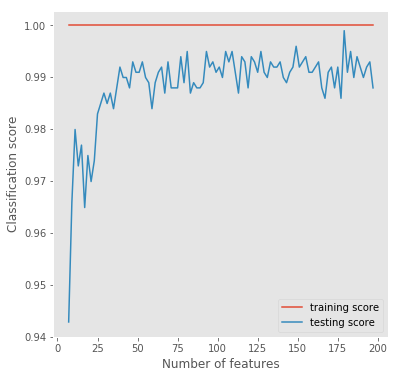

In [58]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(6,6))
plt.plot(feature_numbers,train_scores,label='training score')
plt.plot(feature_numbers,test_scores,label='testing score')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Classification score')
plt.grid(axis='both')

#### Since it seems like ~75 features is optimal, lets try a PCA here

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### We can choose to scale the input data, but it does not make a dramatic change to the results

In [179]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

##### Use PCA to transform the data

In [223]:
pca = PCA(n_components=9)
pca.fit(X)
X_pca = pca.transform(X)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,activities,test_size=0.3)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [225]:
RF.oob_score_

0.9861167320652461

In [226]:
RF.score(X_test,y_test)

0.8172942817294282

#### Its quite odd that the RF performs well on a PCA dataset with only a small number of components. Increasing the number of components reduces the fit

In [2]:
feature_df['activityID'].unique()

NameError: name 'feature_df' is not defined